In [2]:
import numpy as np
import pandas as pd
import os
import os.path
from pathlib import Path
import glob
import matplotlib.pyplot as plt

In [3]:
from skimage import io, color, filters
from skimage.transform import resize, rotate
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
df_debias = pd.read_csv('../data/gz2_debiased.csv')

In [5]:
df_train, df_test = train_test_split(df_debias, test_size=.2)
df_train.shape, df_test.shape

((191511, 38), (47878, 38))

In [6]:
def process_img(path,shape):
    img = plt.imread(path)
    img = img[106:106*3,106:106*3]
    img = resize(img,shape)
    return img

In [87]:
def get_imgs(df, path, shape=(64,64)):
    ids = df.values[:,0].astype(int).astype(str)
    img_batch=[]
    img_ids=[]
    n=0
    for i in tqdm(ids):
        try:
            img = process_img(path+i+'.jpg',shape)
            img_batch.append(img)
            img_ids.append(i)
        except:
            n+=1
#             print(f'Unable to locate img: {i}  Count: {n}')
          
    print(f'Missing Images: {n}')
    img_batch = np.array(img_batch)
    img_ids = np.array(img_ids).astype(int)
    df_ids = pd.DataFrame({'asset_id':img_ids})
    y_batch = pd.merge(df_ids, df, on='asset_id', how='left')
#     y_batch.drop('asset_id', axis=1,inplace=True)
    return img_batch, y_batch

In [51]:
df_train.values[:,0]

array([ 94950.,  26719.,  50861., ...,  27705.,  12348., 151683.])

In [88]:
path = '../images_gz2/images/'
X_train, y_train = get_imgs(df_train[:df_train.shape[0]//32],path)

100%|██████████████████████████████████████| 5984/5984 [00:30<00:00, 196.40it/s]


Missing Images: 4


In [116]:
X_test, y_test = get_imgs(df_test[:df_test.shape[0]//32],path)

100%|██████████████████████████████████████| 1496/1496 [00:07<00:00, 212.41it/s]

Missing Images: 4


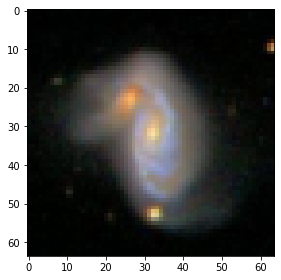

In [91]:
io.imshow(X_train[0])

In [121]:
y_test.drop('asset_id',axis=1,inplace=True)

KeyError: "['asset_id'] not found in axis"

In [123]:
y_train.drop('asset_id',axis=1,inplace=True)
y_train.shape

KeyError: "['asset_id'] not found in axis"

In [130]:
y_test.shape


(1492, 37)

In [102]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K

In [68]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [134]:
def conv(shape):
    model = Sequential()
    #first conv layer and pooling, input is 64,x64 image x3 colors
    model.add(Conv2D(64, (3, 3), input_shape=shape, activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))

    #second conv layer
    model.add(Conv2D(128, (3, 3), input_shape=shape, activation='relu', padding='same'))
    #third conv layer and pooling
    model.add(Conv2D(128, (3, 3), input_shape=shape, activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    #third conv layer
    model.add(Conv2D(256, (3, 3), input_shape=shape, activation='relu', padding='same'))
    #fourth conv layer and pooling
    model.add(Conv2D(256, (3, 3), input_shape=shape, activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    #flatten to dense layers
    model.add(Flatten())
    
#     model.add(Dropout(0.5))
#     model.add(Dense(2048))
#     model.add(Activation('relu'))
    
#     model.add(Dropout(0.5))
#     model.add(Dense(2048))
#     model.add(Activation('relu'))
    
    #output layer
    model.add(Dense(37))
    model.add(Activation('sigmoid'))
    return model

In [135]:
model = conv((64,64,3))
optimizer = Adam(lr=1e-5)
model.compile(loss='mean_squared_error', optimizer= optimizer)
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 16, 16, 256)     

In [136]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
187/187 [==============================] - 80s 428ms/step - loss: 0.1265
Epoch 2/10
187/187 [==============================] - 80s 427ms/step - loss: 0.0844
Epoch 3/10
187/187 [==============================] - 80s 430ms/step - loss: 0.0837
Epoch 4/10
187/187 [==============================] - 81s 432ms/step - loss: 0.0827
Epoch 5/10
187/187 [==============================] - 80s 428ms/step - loss: 0.0808
Epoch 6/10
187/187 [==============================] - 81s 432ms/step - loss: 0.0782
Epoch 7/10
187/187 [==============================] - 80s 430ms/step - loss: 0.0766
Epoch 8/10
187/187 [==============================] - 80s 430ms/step - loss: 0.0753
Epoch 9/10
187/187 [==============================] - 80s 426ms/step - loss: 0.0741
Epoch 10/10
187/187 [==============================] - 80s 425ms/step - loss: 0.0731


In [139]:
predictions = model.predict(X_test)

In [140]:
predictions.shape

(1492, 37)